# CalTrackAI – Risk Management & Monitoring Notebook

This notebook documents and **implements** the Risk Management strategies for the CalTrackAI system across the AI lifecycle:

1. **Problem Definition**
2. **Data Collection**
3. **AI Model Development**
4. **AI Deployment**
5. **Monitoring & Maintenance**
6. **Residual Risk Assessment**

It is intended to be a **technical companion** to the written *Risk Management Strategy* section of the project report, showing
concrete code and checks that support risk identification and mitigation.

---

## Paths

This notebook assumes the CalTrackAI repository has the following relevant items:

- `src/backend/model/resnet50_food101_final.keras` – trained ResNet-50 model
- `src/backend/data/label_map.json` – mapping from class name → index
- `src/backend/data/usda_food_data.csv` – USDA nutrition table used by the API
- `src/backend/data/testing_images/` – small curated folder of example images for sanity checks
- `src/backend/data/feedback.jsonl` – JSON-lines file where user feedback is appended by the backend
- Prometheus is running at `http://localhost:9090` and scraping metrics from the backend (`/metrics`).

In [45]:
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import requests
from rapidfuzz import process, fuzz

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Make plots a bit nicer
plt.style.use("ggplot")


ROOT = Path("..").resolve()
BACKEND_DIR = ROOT / "src" / "backend"
DATA_DIR = BACKEND_DIR / "data"
MODEL_DIR = BACKEND_DIR / "model"

MODEL_PATH = MODEL_DIR / "resnet50_food101_final.keras"
LABEL_MAP_PATH = DATA_DIR / "label_map.json"
USDA_PATH = DATA_DIR / "usda_food_data.csv"
TEST_IMAGES_DIR = DATA_DIR / "testing_images"
FEEDBACK_PATH = DATA_DIR / "feedback.jsonl"

PROMETHEUS_URL = "http://localhost:9090"

print("ROOT:", ROOT)
print("MODEL_PATH:", MODEL_PATH)
print("USDA_PATH:", USDA_PATH)
print("TEST_IMAGES_DIR:", TEST_IMAGES_DIR)
print("FEEDBACK_PATH:", FEEDBACK_PATH)
print("Prometheus URL:", PROMETHEUS_URL)

ROOT: /Users/pranavsambidi/Downloads/CalTrackAI
MODEL_PATH: /Users/pranavsambidi/Downloads/CalTrackAI/src/backend/model/resnet50_food101_final.keras
USDA_PATH: /Users/pranavsambidi/Downloads/CalTrackAI/src/backend/data/usda_food_data.csv
TEST_IMAGES_DIR: /Users/pranavsambidi/Downloads/CalTrackAI/src/backend/data/testing_images
FEEDBACK_PATH: /Users/pranavsambidi/Downloads/CalTrackAI/src/backend/data/feedback.jsonl
Prometheus URL: http://localhost:9090


# 1. Problem Definition – Risk Management

**Goal:** Ensure that CalTrackAI’s problem framing and success criteria are aligned with user needs and do not introduce hidden risks.

### Key Risks

- **Misalignment with user needs**
- **Undefined / unclear success metrics**
- **Ethical risk** (users over-trusting calorie estimates)
- **Stakeholder exclusion** (e.g., people with specific dietary needs)

### Strategy Implemented Here

We explicitly document:

- The **primary objectives** of the system
- The **success metrics** we track in training and monitoring
- A lightweight **requirements “schema”** that acts as structured documentation (not enforced but serves as a checklist).

In [46]:
# Simple structured representation of problem definition & success metrics.
problem_definition = {
    "system_name": "CalTrackAI",
    "high_level_goal": (
        "Estimate nutritional information from food images using a ResNet-50 "
        "model trained on the Food-101 dataset and USDA nutrient data."
    ),
    "primary_users": [
        "Students and individuals who want a quick estimate of calories/macros from photos",
    ],
    "non_goals": [
        "Provide medical-grade dietary advice",
        "Replace professional nutritionists or dieticians",
    ],
    "success_metrics_training": {
        "top1_accuracy_food101": "≥ 0.73 (target)",   
        "top5_accuracy_food101": "≥ 0.91 (target)",   
    },
    "success_metrics_monitoring": {
        "prediction_latency_p95_seconds": "<= 1.0",
        "prediction_error_rate": "< 5%",
        "user_negative_feedback_rate": "< 20%",
    },
    "ethical_safeguards": [
        "UI disclaimer that estimates are approximate and not medical advice",
        "No personalized medical recommendations based on predictions",
    ],
}

print(json.dumps(problem_definition, indent=2))

{
  "system_name": "CalTrackAI",
  "high_level_goal": "Estimate nutritional information from food images using a ResNet-50 model trained on the Food-101 dataset and USDA nutrient data.",
  "primary_users": [
    "Students and individuals who want a quick estimate of calories/macros from photos"
  ],
  "non_goals": [
    "Provide medical-grade dietary advice",
    "Replace professional nutritionists or dieticians"
  ],
  "success_metrics_training": {
    "top1_accuracy_food101": "\u2265 0.73 (target)",
    "top5_accuracy_food101": "\u2265 0.91 (target)"
  },
  "success_metrics_monitoring": {
    "prediction_latency_p95_seconds": "<= 1.0",
    "prediction_error_rate": "< 5%",
    "user_negative_feedback_rate": "< 20%"
  },
  "ethical_safeguards": [
    "UI disclaimer that estimates are approximate and not medical advice",
    "No personalized medical recommendations based on predictions"
  ]
}


# 2. Data Collection – Risk Management

Here we focus on risks in **USDA nutrition data** and **Food-101 label coverage**.

### Key Risks

- **Data quality issues** in `usda_food_data.csv` (missing values, impossible calories/macros).
- **Coverage mismatch** between Food-101 labels and USDA entries (leading to “No nutrition found”).
- Implicit **bias** if some categories are poorly represented in the nutrition table.

### Strategies Implemented

1. **Automated USDA data validation**
   - Check for missing values.
   - Flag out-of-range calories and macro values.
   - Visualize distributions.

2. **Coverage check between Food-101 labels and USDA descriptions**
   - Fuzzy-matching each Food-101 label to the closest USDA description.
   - Flag labels whose best match is below a similarity threshold.


In [47]:
if USDA_PATH.exists():
    usda_df = pd.read_csv(USDA_PATH)
    print(f"Loaded USDA data with shape: {usda_df.shape}")
else:
    usda_df = None
    print("WARNING: USDA file not found at:", USDA_PATH)

Loaded USDA data with shape: (101, 11)


,query,fdcId,description,dataType,calories,protein,fat,carbohydrates,source_label,query_used,match_score
0,apple pie,2084465,APPLE PIE,Branded,300.0,33.30,8.33,41.70,apple_pie,apple pie,100.0
1,baby back ribs,1457876,BABY BACK RIBS,Branded,170.0,18.80,9.82,0.00,baby_back_ribs,baby back ribs,100.0
2,baklava,2708044,Baklava,Survey (FNDDS),440.0,6.58,29.34,37.55,baklava,baklava,100.0
3,beef carpaccio,2660667,THINLY SLICED BEEF,Branded,179.0,14.30,12.90,1.43,beef_carpaccio,thinly sliced raw beef appetizer,72.0
4,beef tartare,2706394,Steak tartare,Survey (FNDDS),216.0,17.45,15.60,0.34,beef_tartare,beef tartare,100.0



Missing values per column:
query            0
fdcId            0
description      0
dataType         0
calories         0
protein          0
fat              0
carbohydrates    0
source_label     0
query_used       0
match_score      0
dtype: int64

USDA value range issues:
- calories_out_of_range: 0 rows
- protein_out_of_range: 0 rows
- fat_out_of_range: 0 rows
- carbohydrates_out_of_range: 2 rows


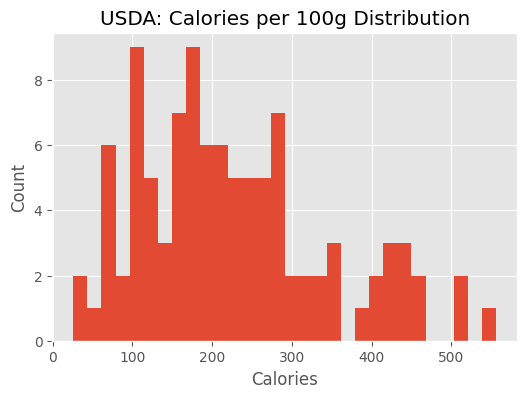

In [48]:
if usda_df is not None:
    display(usda_df.head())

    # Basic missingness
    print("\nMissing values per column:")
    print(usda_df.isna().sum())

    # Define plausible ranges
    def within_range(series, low, high):
        return (series >= low) & (series <= high)

    quality_report = {}

    if "calories" in usda_df.columns:
        cals = usda_df["calories"]
        quality_report["calories_out_of_range"] = (~within_range(cals, 0, 1200)).sum()

    for macro in ["protein", "fat", "carbohydrates"]:
        if macro in usda_df.columns:
            s = usda_df[macro]
            quality_report[f"{macro}_out_of_range"] = (~within_range(s, 0, 100)).sum()

    print("\nUSDA value range issues:")
    for k, v in quality_report.items():
        print(f"- {k}: {v} rows")

    # Plot distribution of calories (if present)
    if "calories" in usda_df.columns:
        plt.figure(figsize=(6, 4))
        usda_df["calories"].dropna().hist(bins=30)
        plt.title("USDA: Calories per 100g Distribution")
        plt.xlabel("Calories")
        plt.ylabel("Count")
        plt.show()

### 2.2 Food-101 label coverage vs USDA entries

We check that each Food-101 label has a reasonably good match in `usda_food_data.csv`
using **RapidFuzz**.

- Threshold: similarity score ≥ **60** (same as backend logic).
- We record labels that fall below the threshold so we can either:
  - fix USDA descriptions, or
  - add manual overrides / custom entries.

In [49]:
# Food-101 label list used throughout the project
food_101_labels = sorted(set([
    "apple_pie","baby_back_ribs","baklava","beef_carpaccio","beef_tartare",
    "beet_salad","beignets","bibimbap","bread_pudding","breakfast_burrito",
    "bruschetta","caesar_salad","cannoli","caprese_salad","carrot_cake",
    "ceviche","cheesecake","cheese_plate","chicken_curry","chicken_quesadilla",
    "chicken_wings","chocolate_cake","chocolate_mousse","churros","clam_chowder",
    "club_sandwich","crab_cakes","creme_brulee","croque_madame","cup_cakes",
    "deviled_eggs","donuts","dumplings","edamame","eggs_benedict","escargots",
    "falafel","filet_mignon","fish_and_chips","foie_gras","french_fries",
    "french_onion_soup","french_toast","fried_calamari","fried_rice","frozen_yogurt",
    "garlic_bread","gnocchi","greek_salad","grilled_cheese_sandwich","grilled_salmon",
    "guacamole","gyoza","hamburger","hot_and_sour_soup","hot_dog","huevos_rancheros",
    "hummus","ice_cream","lasagna","lobster_bisque","lobster_roll_sandwich",
    "macaroni_and_cheese","macarons","miso_soup","mussels","nachos","omelette",
    "onion_rings","oysters","pad_thai","paella","pancakes","panna_cotta",
    "peking_duck","pho","pizza","pork_chop","poutine","prime_rib",
    "pulled_pork_sandwich","ramen","ravioli","red_velvet_cake","risotto","samosa",
    "sashimi","scallops","seaweed_salad","shrimp_and_grits","spaghetti_bolognese",
    "spaghetti_carbonara","spring_rolls","steak","strawberry_shortcake","sushi",
    "tacos","takoyaki","tiramisu","tuna_tartare","waffles"
]))

len(food_101_labels)

101

,label,query,matched_description,similarity_score
0,apple_pie,apple pie,APPLE PIE,100.0
1,baby_back_ribs,baby back ribs,BABY BACK RIBS,100.0
2,baklava,baklava,Baklava,100.0
3,beef_carpaccio,beef carpaccio,"SLOW ROASTED BEEF, ROAST BEEF",85.5
4,beef_tartare,beef tartare,THINLY SLICED BEEF,85.5



Labels with similarity < 60: 2


,label,query,matched_description,similarity_score
73,panna_cotta,panna cotta,PAD THAI,52.631579
39,foie_gras,foie gras,ICE CREAM,55.555556


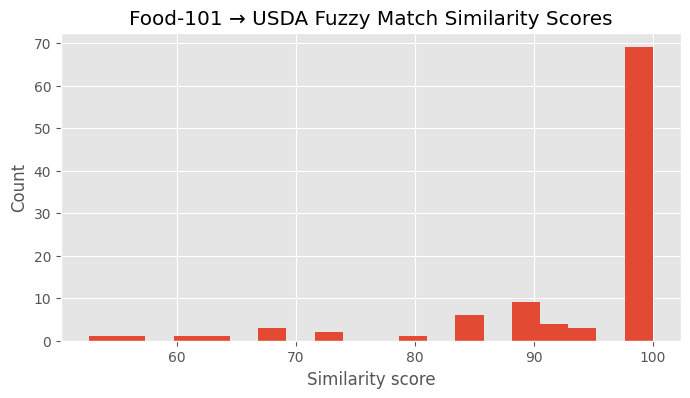

In [50]:
# %%
coverage_results = []

if usda_df is not None:
    # Lowercase descriptions for fuzzy search
    usda_df["description_lower"] = usda_df["description"].astype(str).str.lower()

    for label in food_101_labels:
        query = label.replace("_", " ")
        match = process.extractOne(
            query,
            usda_df["description_lower"],
            scorer=fuzz.WRatio
        )
        if match:
            best_desc, score, idx = match
            coverage_results.append({
                "label": label,
                "query": query,
                "matched_description": usda_df.loc[idx, "description"],
                "similarity_score": score
            })
        else:
            coverage_results.append({
                "label": label,
                "query": query,
                "matched_description": None,
                "similarity_score": 0
            })

coverage_df = pd.DataFrame(coverage_results)
display(coverage_df.head())

if not coverage_df.empty:
    # Any labels with weak matches?
    weak_matches = coverage_df[coverage_df["similarity_score"] < 60]
    print(f"\nLabels with similarity < 60: {len(weak_matches)}")
    display(weak_matches.sort_values("similarity_score"))

    plt.figure(figsize=(8, 4))
    coverage_df["similarity_score"].hist(bins=20)
    plt.title("Food-101 → USDA Fuzzy Match Similarity Scores")
    plt.xlabel("Similarity score")
    plt.ylabel("Count")
    plt.show()
else:
    print("No coverage data computed (USDA not loaded).")

# 3. AI Model Development – Risk Management

Here we focus on risk related to:

- **Overfitting / low generalization**
- **Unreliable predictions (low confidence) on test images**

### Strategies Implemented

1. **Sanity-check predictions on curated testing images**
   - Use the *production* ResNet-50 model.
   - Run inference on `src/backend/data/testing_images/`.
   - Record top-1 label & confidence.
   - Flag images with confidence below a threshold (e.g., 0.6).

2. This is not a full evaluation on Food-101, but a **lightweight regression test** to catch obvious failures.

In [51]:
model = None
idx_to_label = None

def load_model_and_labels():
    global model, idx_to_label
    if model is None:
        if not MODEL_PATH.exists():
            print("WARNING: Model file not found at:", MODEL_PATH)
            return None, None
        print("Loading model...")
        model = load_model(MODEL_PATH)

    if idx_to_label is None:
        if not LABEL_MAP_PATH.exists():
            print("WARNING: label_map.json not found at:", LABEL_MAP_PATH)
            return model, None
        with open(LABEL_MAP_PATH, "r") as f:
            label_map = json.load(f)
        # label_map is name -> index; invert it
        idx_to_label = {v: k for k, v in label_map.items()}

    return model, idx_to_label

model, idx_to_label = load_model_and_labels()

Loading model...


In [52]:
def predict_image(img_path, model, idx_to_label, top_k=5):
    """Run prediction on a single image and return top-k labels & confidences."""
    img = keras_image.load_img(img_path, target_size=(224, 224))
    arr = keras_image.img_to_array(img)
    arr = preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)

    preds = model.predict(arr)
    probs = preds[0]
    top_indices = probs.argsort()[-top_k:][::-1]

    out = []
    for idx in top_indices:
        out.append({
            "label": idx_to_label.get(int(idx), f"idx_{idx}"),
            "confidence": float(probs[idx])
        })
    return out

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Evaluated 7 testing images.


,image,top1_label,top1_confidence
0,183260.jpg,samosa,0.698328
1,21443.jpg,samosa,0.992911
2,25414.jpg,spring_rolls,0.999984
3,328349.jpg,waffles,1.000000
4,4919.jpg,donuts,0.999994
5,57594.jpg,french_fries,0.996689
6,6229.jpg,huevos_rancheros,0.440149



Images with confidence < 0.6: 1


,image,top1_label,top1_confidence,top5
6,6229.jpg,huevos_rancheros,0.440149,"[{'label': 'huevos_rancheros', 'confidence': 0..."


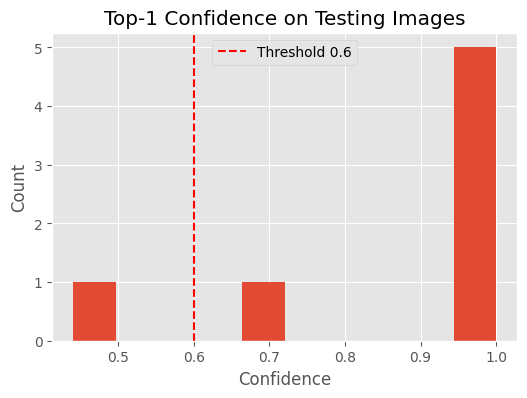

In [53]:
if model is None or idx_to_label is None:
    print("Model or label map not loaded; skipping test image predictions.")
else:
    if not TEST_IMAGES_DIR.exists():
        print("WARNING: testing_images folder not found at:", TEST_IMAGES_DIR)
    else:
        results = []
        for img_name in sorted(os.listdir(TEST_IMAGES_DIR)):
            img_path = TEST_IMAGES_DIR / img_name
            if not img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                continue
            top5 = predict_image(img_path, model, idx_to_label, top_k=5)
            top1 = top5[0]
            results.append({
                "image": img_name,
                "top1_label": top1["label"],
                "top1_confidence": top1["confidence"],
                "top5": top5,
            })

        test_df = pd.DataFrame(results)
        print(f"Evaluated {len(test_df)} testing images.")
        display(test_df[["image", "top1_label", "top1_confidence"]])

        # Flag low-confidence predictions
        THRESHOLD = 0.6
        low_conf = test_df[test_df["top1_confidence"] < THRESHOLD]
        print(f"\nImages with confidence < {THRESHOLD}: {len(low_conf)}")
        display(low_conf)

        # Plot confidence distribution
        plt.figure(figsize=(6, 4))
        test_df["top1_confidence"].hist(bins=10)
        plt.axvline(THRESHOLD, color="red", linestyle="--", label=f"Threshold {THRESHOLD}")
        plt.title("Top-1 Confidence on Testing Images")
        plt.xlabel("Confidence")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

# 4. AI Deployment – Risk Management

Deployment risks include:

- API becoming unavailable
- High latency
- Misconfigurations between services

### Strategies Implemented

1. **Health check of live backend API**
   - Simple GET `/` and sample POST `/predict` request.

2. **Integration with Prometheus**
   - The backend exposes `/metrics`.
   - Here we query Prometheus directly to inspect latency metrics.

> Note: These cells assume Docker Compose stack is running:
> `docker-compose -f deployment/docker-compose.yml up`

In [54]:
# 4.1 Health check of backend API

BACKEND_URL = "http://localhost:3000"

def check_backend_health():
    try:
        r = requests.get(BACKEND_URL + "/")
        print("GET / status:", r.status_code)
        print("Response:", r.text[:200])
    except Exception as e:
        print("Backend health check failed:", e)

check_backend_health()

GET / status: 200
Response: CalTrackAI API is running with Prometheus metrics!


In [55]:
# 4.2 Query Prometheus for backend latency metrics

def query_prometheus(query, prom_url=PROMETHEUS_URL):
    """Helper to query Prometheus HTTP API."""
    url = f"{prom_url}/api/v1/query"
    try:
        resp = requests.get(url, params={"query": query})
        resp.raise_for_status()
        data = resp.json()
        if data.get("status") != "success":
            print("Prometheus query not successful:", data)
            return None
        return data["data"]["result"]
    except Exception as e:
        print("Error querying Prometheus:", e)
        return None

# Example query: average prediction latency over last 5 minutes
prom_query = 'rate(prediction_latency_seconds_sum[5m]) / rate(prediction_latency_seconds_count[5m])'
latency_result = query_prometheus(prom_query)

print("Raw latency query result:")
print(json.dumps(latency_result, indent=2))

Raw latency query result:
[
  {
    "metric": {
      "instance": "backend:3000",
      "job": "caltrack-backend"
    },
    "value": [
      1764060107.588,
      "0.221909761428833"
    ]
  }
]


In [56]:
def extract_scalar_from_vector(result):
    """Simplified extractor: picks first series and last value."""
    if not result:
        return None
    series = result[0]
    values = series.get("value")
    if not values or len(values) < 2:
        return None
    ts, val = values
    try:
        return float(val)
    except Exception:
        return None

avg_latency = extract_scalar_from_vector(latency_result)
if avg_latency is not None:
    print(f"Approx. average prediction latency over last 5m: {avg_latency:.4f} seconds")
else:
    print("Could not parse latency from Prometheus result (maybe no traffic yet?).")

Approx. average prediction latency over last 5m: 0.2219 seconds


# 5. Monitoring & Maintenance – Risk Management

After deployment, we must monitor:

- **System performance** (already via Prometheus).
- **User feedback** (helpful vs not helpful).
- Early signs of **model drift or dissatisfaction**.

### Strategies Implemented

1. **Feedback log analysis**
   - Read `feedback.jsonl` written by backend.
   - Estimate ratio of positive vs negative feedback.
   - Inspect distribution of confidences when users say “No”.

2. **Heuristic drift / dissatisfaction indicator**
   - High fraction of “No” feedback or very low confidences can trigger retraining or deeper review.

In [57]:
if FEEDBACK_PATH.exists():
    feedback_records = []
    with open(FEEDBACK_PATH, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                feedback_records.append(json.loads(line))
            except json.JSONDecodeError:
                print("Skipping invalid JSON line:", line[:80])

    print(f"Loaded {len(feedback_records)} feedback records.")
else:
    feedback_records = []
    print("WARNING: feedback.jsonl not found at:", FEEDBACK_PATH)

Loaded 3 feedback records.


,prediction,nutrition,feedback_type,comment,label,confidence
0,"{'confidence': 0.9997199177742004, 'label': 's...","{'calories': 310.0, 'carbohydrates': 33.16, 'd...",None,,samosa,0.999720
1,"{'confidence': 0.35873734951019287, 'label': '...","{'calories': 440.0, 'carbohydrates': 37.55, 'd...",yes,good,baklava,0.358737
2,"{'confidence': 0.9925985336303711, 'label': 's...","{'calories': 310.0, 'carbohydrates': 33.16, 'd...",yes,good,samosa,0.992599



Feedback type counts:
feedback_type
yes     2
None    1
Name: count, dtype: int64

Positive feedback rate: 66.67%
Negative feedback rate: 0.00%


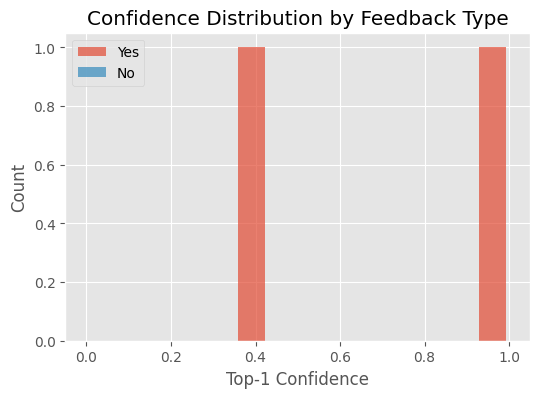

In [58]:
if feedback_records:
    fb_df = pd.DataFrame(feedback_records)

    # Normalize keys that might be nested: prediction.confidence, feedback_type, etc.
    def extract_confidence(row):
        pred = row.get("prediction", {})
        return pred.get("confidence", None)

    def extract_label(row):
        pred = row.get("prediction", {})
        return pred.get("label", None)

    def extract_feedback_type(row):
        return row.get("feedback_type", None)

    fb_df["label"] = fb_df.apply(extract_label, axis=1)
    fb_df["confidence"] = fb_df.apply(extract_confidence, axis=1)
    fb_df["feedback_type"] = fb_df.apply(extract_feedback_type, axis=1)

    display(fb_df.head())

    # Basic stats
    print("\nFeedback type counts:")
    print(fb_df["feedback_type"].value_counts(dropna=False))

    # Compute negative feedback rate
    total_fb = len(fb_df)
    neg_fb = (fb_df["feedback_type"] == "no").sum()
    pos_fb = (fb_df["feedback_type"] == "yes").sum()

    neg_rate = neg_fb / total_fb if total_fb > 0 else 0
    pos_rate = pos_fb / total_fb if total_fb > 0 else 0

    print(f"\nPositive feedback rate: {pos_rate:.2%}")
    print(f"Negative feedback rate: {neg_rate:.2%}")

    # Confidence distribution by feedback type
    plt.figure(figsize=(6, 4))
    fb_df[fb_df["feedback_type"] == "yes"]["confidence"].dropna().hist(
        alpha=0.7, label="Yes")
    fb_df[fb_df["feedback_type"] == "no"]["confidence"].dropna().hist(
        alpha=0.7, label="No")
    plt.title("Confidence Distribution by Feedback Type")
    plt.xlabel("Top-1 Confidence")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
else:
    print("No feedback records to analyze yet.")

5.2 Heuristic drift / dissatisfaction indicator

We can define simple thresholds:

- If **negative feedback rate > 30%**, flag **High risk – needs review**.
- If **average confidence for “no” feedback < 0.5**, suspect **data/model drift** or mismatch between user expectations and model behavior.

In [59]:
if feedback_records:
    NEG_THRESHOLD = 0.30
    CONF_THRESHOLD = 0.5

    neg_rate = neg_rate  # already computed above
    avg_conf_no = fb_df[fb_df["feedback_type"] == "no"]["confidence"].mean()

    print(f"Negative feedback rate: {neg_rate:.2%}")
    print(f"Average confidence (when feedback = 'no'): {avg_conf_no:.3f}")

    if neg_rate > NEG_THRESHOLD:
        print("\nALERT: Negative feedback rate is HIGH. Investigation recommended.")
    else:
        print("\nNegative feedback rate is within acceptable range.")

    if not np.isnan(avg_conf_no) and avg_conf_no < CONF_THRESHOLD:
        print("ALERT: Average confidence on 'no' feedback is LOW. Possible drift or label mismatch.")
    else:
        print("Confidence on 'no' feedback does not indicate clear drift.")
else:
    print("No feedback-based drift indicators available yet.")

Negative feedback rate: 0.00%
Average confidence (when feedback = 'no'): nan

Negative feedback rate is within acceptable range.
Confidence on 'no' feedback does not indicate clear drift.


# 6. Residual Risk Assessment

This notebook **implements** several concrete risk management strategies:

- **Problem Definition**
  - Documented system goals, non-goals, and success metrics in a structured format.

- **Data Collection**
  - Automated validation of USDA nutrition values.
  - Fuzzy-coverage check between Food-101 labels and USDA descriptions.

- **Model Development**
  - Sanity-check predictions on curated testing images.
  - Flag low-confidence cases for manual review.

- **Deployment**
  - Health-check endpoint for the backend.
  - Prometheus integration and example latency query.

- **Monitoring & Maintenance**
  - Analysis of `feedback.jsonl` (positive vs negative feedback).
  - Heuristic drift/dissatisfaction indicators based on feedback and confidence.

These steps reduce, but do not eliminate, risk. The **residual risks** (e.g., dataset bias, drift as new foods appear, misinterpretation of calorie estimates) are documented in the written Risk Management section of the report, along with their **Likelihood–Impact** classifications.

You can now reference this notebook directly in your report as evidence of *technically implemented* risk management strategies.